In [1]:

import numpy as np 
import pandas as pd 
import os
import gc
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from tqdm.autonotebook import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import keras.backend as K
from keras.models import Sequential
from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
train_df = pd.read_csv("../input/happy-whale-and-dolphin/train.csv")
#train_df=train_df.drop_duplicates(subset=['individual_id'],keep='last')
train_df.head()

,image,species,individual_id
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [3]:
train_df.shape


(51033, 3)

In [4]:
def Loading_Images(data, m, dataset):
    print("Loading images")
    X_train = np.zeros((m, 32, 32, 3))
    count = 0
    for fig in tqdm(data['image']):
        img = image.load_img("../input/happy-whale-and-dolphin/"+dataset+"/"+fig, target_size=(32, 32, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_train[count] = x
        count += 1
    return X_train

def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    return y, label_encoder


In [5]:
X = Loading_Images(train_df, train_df.shape[0], "train_images")
X /= 255

Loading images


  0%|          | 0/51033 [00:00<?, ?it/s]

In [6]:
y, label_encoder = prepare_labels(train_df['individual_id'])
y.shape

(51033, 15587)

In [7]:
gc.collect()


82

In [8]:
model = Sequential()

model.add(Conv2D(32, (6, 6), strides = (1, 1), input_shape = (32, 32, 3)))
model.add(BatchNormalization(axis = 3))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), strides = (1,1)))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3)))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.85))

model.add(Dense(y.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

2022-02-13 09:26:32.610930: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 32)        3488      
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 27, 27, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 64)          0

In [9]:
history = model.fit(X, y, epochs=150, batch_size=128, verbose=1)
model.save('./last.h5')

2022-02-13 09:26:44.876147: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/150
399/399 [==============================] - 66s 163ms/step - loss: 8.8886 - accuracy: 0.0066
Epoch 2/150
399/399 [==============================] - 52s 131ms/step - loss: 8.4463 - accuracy: 0.0096
Epoch 3/150
399/399 [==============================] - 53s 133ms/step - loss: 8.2452 - accuracy: 0.0109
Epoch 4/150
399/399 [==============================] - 54s 136ms/step - loss: 8.1128 - accuracy: 0.0114
Epoch 5/150
399/399 [==============================] - 53s 133ms/step - loss: 7.9975 - accuracy: 0.0124
Epoch 6/150
399/399 [==============================] - 55s 138ms/step - loss: 7.8992 - accuracy: 0.0127
Epoch 7/150
399/399 [==============================] - 54s 136ms/step - loss: 7.8161 - accuracy: 0.0138
Epoch 8/150
399/399 [==============================] - 54s 135ms/step - loss: 7.7310 - accuracy: 0.0140
Epoch 9/150
399/399 [==============================] - 54s 134ms/step - loss: 7.6569 - accuracy: 0.0146
Epoch 10/150
399/399 [==============================] - 54s 136m

In [10]:
del X
del y
gc.collect()

946

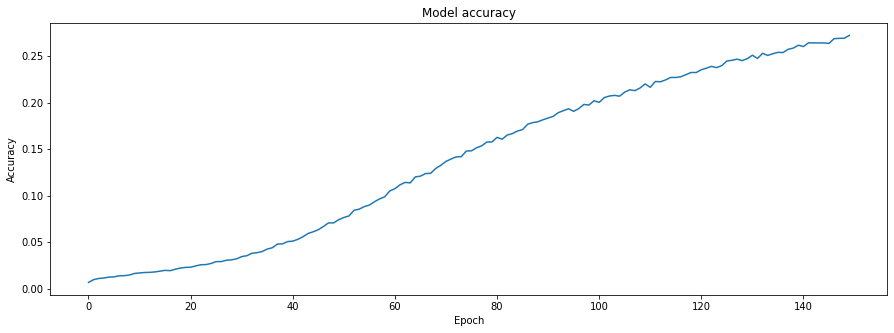

In [11]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

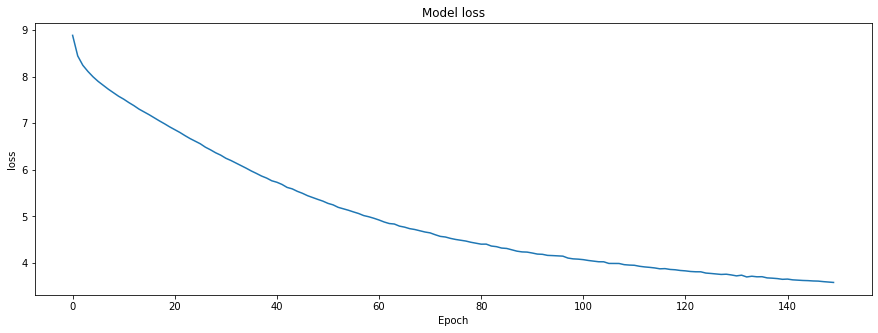

In [12]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.show()

In [13]:
test = os.listdir("../input/happy-whale-and-dolphin/test_images")
print(len(test))

27956


In [14]:
col = ['image']
test_df = pd.DataFrame(test, columns=col)
test_df['predictions'] = ''
#test_df=test_df.head(n=250)
batch_size=5000
batch_start = 0
batch_end = batch_size
L = len(test_df)

while batch_start < L:
    limit = min(batch_end, L)
    test_df_batch = test_df.iloc[batch_start:limit]
    print(type(test_df_batch))
    X = Loading_Images(test_df_batch, test_df_batch.shape[0], "test_images")
    X /= 255
    predictions = model.predict(np.array(X), verbose=1)
    for i, pred in enumerate(predictions):
        p=pred.argsort()[-5:][::-1]
        idx=-1
        s=''
        s1=''
        s2=''
        for x in p:
            idx=idx+1
            if pred[x]>0.6:
                s1 = s1 + ' ' +  label_encoder.inverse_transform(p)[idx]
            else:
                s2 = s2 + ' ' + label_encoder.inverse_transform(p)[idx]
        s= s1 + ' new_individual' + s2
        s = s.strip(' ')
        test_df.loc[ batch_start + i, 'predictions'] = s
    batch_start += batch_size   
    batch_end += batch_size
    del X
    del test_df_batch
    del predictions
    gc.collect()
    

<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 3s 15ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 3s 18ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 14ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 14ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/5000 [00:00<?, ?it/s]

157/157 [==============================] - 2s 13ms/step
<class 'pandas.core.frame.DataFrame'>
Loading images


  0%|          | 0/2956 [00:00<?, ?it/s]

93/93 [==============================] - 1s 13ms/step


In [15]:
test_df.to_csv('submission.csv',index=False)
test_df.head()

,image,predictions
0,cd50701ae53ed8.jpg,new_individual 74745cb94379 9ab8c57f10bc 81459...
1,177269f927ed34.jpg,new_individual 48503390869b 7f97eddd77da 5ca6e...
2,9137934396d804.jpg,new_individual 7345c813e0f3 8073cf9e6850 c024e...
3,c28365a55a0dfe.jpg,new_individual 37c7aba965a5 114207cab555 2e0b3...
4,1a40b7b382923a.jpg,new_individual 37c7aba965a5 114207cab555 19fbb...
